In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt_colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

import glob

import scipy.fft as fourier
import scipy.signal as signal
from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
def crear_csvs():

    filenames = glob.glob('Datos de fotoconductividad/*.txt')
    for filename in filenames:
        file = open(filename)

        lines = []
        i = 0
        try:
            for line in file:
                i+=1
                if i>=17:
                    lines.append(line[:-1].split('\t'))
            data = pd.DataFrame(lines,columns=['Tiempo [s]','Voltaje [V]','Corriente [A]','Luz'])
            data.to_csv(filename[:-4]+'.csv',index=False)
        except BaseException as error:
            print('Error de lectura: '+filename)
            print(f'{error=}')
        file.close()
    
    filenames = glob.glob('Datos de curvas IV/*.txt')
    for filename in filenames:
        file = open(filename)

        lines = []
        i = 0
        try:
            for line in file:
                _,I,_,V,_ = line[:-1].split('\t')
                lines.append([I,V])
            data = pd.DataFrame(lines,columns=['Corriente [A]','Voltaje [V]'])
            data.to_csv(filename[:-4]+'.csv',index=False)
        except BaseException as error:
            print('Error de lectura: '+filename)
            print(f'{error=}')
        file.close()

# crear_csvs()

In [22]:
def procesar_datos_foto(nombre,axes,rango=(0,100000),filter_function=None,filter_cut=None,ajuste=False,ax_single=False,reg_avg=False):
    data = pd.read_csv(nombre)
    corriente = np.array(data['Corriente [A]']*1e6)[rango[0]:rango[1]]
    tiempo = np.array(data['Tiempo [s]'][rango[0]:rango[1]])
    luz = np.array(data['Luz'])[rango[0]:rango[1]]
    
    fontsize = 12
    
    delta_y = np.amax(corriente)-np.amin(corriente)
    
    rango_calculos = (tiempo>120) & (tiempo<240)
    I0 = np.amin(corriente[rango_calculos])
    Delta_I0 = np.amax(corriente[rango_calculos]) - I0
    tau = -1.
    
    if filter_function is not None:
        
        corriente = filter_function(corriente,tiempo,cut)
        
        
        I0 = np.amin(corriente[rango_calculos])
        Delta_I0 = np.amax(corriente[rango_calculos]) - I0
    
    if ajuste:
        corriente = normalizar(tiempo,corriente)
        
        I0 = np.amin(corriente[rango_calculos])
        Delta_I0 = np.amax(corriente[rango_calculos]) - I0
        
    
    if ax_single:
        inicio = 780
        rango_up = (tiempo>inicio) & (tiempo<inicio+60)
        tiempo_up = (tiempo-inicio)[rango_up]
        corriente_up = corriente[rango_up]
        luz_up = luz[rango_up]
        
        
        popt,pcov = ajuste_exp(tiempo_up,corriente_up,metadata=True)
        I0,Delta_I0,tau = popt[2],popt[0],popt[1]
    
    if reg_avg:
        params = []
        sigmas = []
        for inicio in range(60,600,120):
            rango_up = (tiempo>inicio) & (tiempo<inicio+60)
            tiempo_up = (tiempo-inicio)[rango_up]
            corriente_up = corriente[rango_up]
            luz_up = luz[rango_up]
        
            popt,pcov = ajuste_exp(tiempo_up,corriente_up,metadata=True)
#             print(inicio,popt)
            params.append(popt)
            sigmas.append([np.sqrt(pcov[j,j]) for j in range(len(popt))] )
            
            ajuste_up = exponencial_ajuste(tiempo_up,*popt)
        
#         params = np.array(params).T
#         sigmas = np.array(sigmas).T
        
        sigmas = np.std(params,axis=0)
        params = np.mean(params,axis=0)
        
#         params = np.array([promedio(0*params[i],params[i],sigmas[i]) for i in range(len(params)) ])
#         sigmas = params[:,1]
#         params = params[:,0]
#         print(params,'\n',sigmas)
        
        tiempo = np.linspace(0,60)
        
        corriente = exponencial_ajuste(tiempo,*params)
        
        I0,Delta_I0,tau = params[2],params[0],params[1]
        return (corriente,tiempo,luz),(I0,Delta_I0,tau),(sigmas[2],sigmas[0],sigmas[1])


    return (corriente,tiempo,luz),(I0,Delta_I0,tau)

In [23]:
def extraer_datos_foto(nombre,axes,rango=(0,100000),filter_function=None,filter_cut=None,ajuste=None,ax_single=None,reg_avg=None):
    
    (corriente,tiempo,luz),(I0,Delta_I0,tau) = procesar_datos_foto(nombre,axes,rango)
    fontsize = 12
    
    fig_original = axes[0]
    fig_original.plot(tiempo,corriente)
    fig_original.fill_between(tiempo,luz*1.5*np.amax(corriente),alpha=0.15,color='darkorange',label='Encendido')
    
    delta_y = np.amax(corriente)-np.amin(corriente)
    fig_original.set_xlim(0,900)
    fig_original.set_ylim(np.amin(corriente),np.amin(corriente)+(delta_y*1.))
    fig_original.legend(fontsize=fontsize)
    fig_original.label_outer()
    fig_original.set_xlabel('Tiempo [s]',fontsize=fontsize)
    fig_original.set_ylabel('Corriente [$\mu$A]',fontsize=fontsize)
    fig_original.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    fig_original.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    if filter_function is not None:
        
        (corriente,tiempo,luz),(I0,Delta_I0,tau) = procesar_datos_foto(nombre,axes,rango,filter_function,filter_cut)
        
        fig_filtrada = axes[1]
        fig_filtrada.plot(tiempo,corriente)
        fig_filtrada.fill_between(tiempo,luz*1.5*np.amax(corriente),alpha=0.15,color='darkorange',label='Encendido')
        
        delta_y = np.amax(corriente)-np.amin(corriente)
        fig_filtrada.set_xlim(0,900)
        fig_filtrada.set_ylim(np.amin(corriente),np.amin(corriente)+(delta_y*1.))
        fig_filtrada.label_outer()
        fig_filtrada.set_xlabel('Tiempo [s]',fontsize=fontsize)
        fig_filtrada.set_ylabel('Corriente [$\mu$A] \n Filtrada',fontsize=fontsize)
        fig_filtrada.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        fig_filtrada.yaxis.set_major_locator(plt.MaxNLocator(4))
        
        fig_original.set_ylabel('Original')
    
    if ajuste is not None:
        
        (corriente,tiempo,luz),(I0,Delta_I0,tau) = procesar_datos_foto(nombre,axes,rango,filter_function,filter_cut,
                                                                  ajuste is not None)
        
        fig_normalizada = axes[2]
        fig_normalizada.plot(tiempo,corriente)
        fig_normalizada.fill_between(tiempo,luz*1.5*np.amax(corriente),alpha=0.15,color='darkorange',label='Encendido')
        
        delta_y = np.amax(corriente)-np.amin(corriente)
        fig_normalizada.set_xlim(0,900)
        fig_normalizada.set_ylim(np.amin(corriente)-(delta_y*0.2),np.amin(corriente)+(delta_y*1.2))
        fig_normalizada.label_outer()
        fig_normalizada.set_xlabel('Tiempo [s]',fontsize=fontsize)
        fig_normalizada.set_ylabel('Nivelada',fontsize=fontsize)
        fig_normalizada.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        fig_normalizada.yaxis.set_major_locator(plt.MaxNLocator(4))
        
    
    if ax_single is not None:
        inicio = 780
        rango_up = (tiempo>inicio) & (tiempo<inicio+60)
        tiempo_up = (tiempo-inicio)[rango_up]
        corriente_up = corriente[rango_up]
        luz_up = luz[rango_up]
        
#         rango_down = (tiempo>180) & (tiempo<240)
#         tiempo_down = (tiempo-180)[rango_down]
#         corriente_down = corriente[rango_down]

        (corriente,tiempo,luz),(I0,Delta_I0,tau) = procesar_datos_foto(nombre,axes,rango,filter_function,filter_cut,
                                                                  ajuste is not None,ax_single is not None)
        
        ajuste_up = exponencial_ajuste(tiempo_up,Delta_I0,tau,I0)
        
        ax_single.scatter(tiempo,corriente,label='Mediciones')
        ax_single.plot(tiempo_up+inicio,ajuste_up,c='r',label='Ajuste')
        ax_single.fill_between(tiempo,luz*1.5*np.amax(corriente_up),alpha=0.15,color='darkorange')
        ax_single.set_xlim(inicio-10,inicio+60+10)
        deltaY = np.amax(corriente_up)-np.amin(corriente_up)
        ax_single.set_ylim(np.amin(corriente_up)-deltaY*0.1,np.amin(corriente_up)+deltaY*1.1 )
        ax_single.set_xlabel('Tiempo [s]')
        ax_single.legend()
    
    if reg_avg is not None:
        (corriente,tiempo,luz),(I0,Delta_I0,tau),(sigmaI,sigmaDelta,sigmaTau) = procesar_datos_foto(nombre,axes,rango,filter_function,filter_cut,
                                                                  ajuste is not None,ax_single is not None,reg_avg is not None)
            
        reg_avg.plot(tiempo,corriente)
        reg_avg.fill_between(tiempo,1.2*(np.amax(corriente)-np.amin(corriente))+np.amin(corriente),alpha=0.15,color='darkorange')
        reg_avg.set_ylim(np.amin(corriente),1.2*(np.amax(corriente)-np.amin(corriente))+np.amin(corriente))
        reg_avg.set_title( '$I_0 = {:.3f}\pm{:.3f}$ \t $\Delta I_0$ = {:.4f}$\pm${:.4f} \t $ \tau = {:.2f}\pm{:.2f}$'.format(
            I0,sigmaI,Delta_I0,sigmaDelta,tau,sigmaTau) )


    return I0,Delta_I0,tau

In [20]:
def calcular_area_cm2():
    A1 = 17/2
    A2 = 17*np.cos(np.arcsin(3*2/17))
    A3 = 17*np.cos(np.arcsin(6*2/17))
    
    AT = A1+2*A2+2*A3
    
    return AT*1e-2

def calcular_desempeño(I0,Delta_I0,power_perc,sigma_I0=0.,sigma_DI=0.):
    power_frac = power_perc/100
#     Irradiancia = 100e-3 # W/cm2
#     Irradiancia = 90e-3 * power_frac
#     Irradiancia = 12.675e-3 # Para 15%
#     Irradiancia = 12.675e-3 *9
    Irradiancia = 12.70e-3*power_frac
    A_act = np.pi*(1.7/2)**2
    A_enf = calcular_area_cm2()
#     P = 5.79*1.1e-2
    P = Irradiancia*A_act
    r = Delta_I0*A_enf/P
    s = Delta_I0/I0
    
    Sr = sigma_DI*A_enf/P
    Ss = np.sqrt( (sigma_DI/I0)**2 + (sigma_I0*Delta_I0/I0**2)**2)
    
    return r,s,Sr,Ss

def basic_filter(corriente,tiempo,cut):
    origin = corriente[0]
#     sos = signal.butter(11, cut, 'bp', fs=1/9e-3, output='sos')
    sos = signal.butter(11, cut, 'lp', fs=1/9e-3, output='sos')
    filtered = signal.sosfiltfilt(sos, corriente)
    shift = filtered[0]
#     filtered[(tiempo<60)] = np.amin(filtered[(tiempo>60)])
    filtered += (origin-shift)
    return filtered

def basic_filter_smallinterval(corriente,tiempo,cut):
    origin = corriente[0]
#     sos = signal.butter(11, cut, 'bp', fs=1/9e-3, output='sos')
    sos = signal.butter(11, cut, 'lp', fs=1/4e-3, output='sos')
    filtered = signal.sosfiltfilt(sos, corriente)
    shift = filtered[0]
#     filtered[(tiempo<60)] = np.amin(filtered[(tiempo>60)])
    filtered += (origin-shift)
    return filtered

def constante_ajuste(x,a):
    return a

def cuadratica_ajuste(x,a,b,c):
    return a*x**2 + b*x + c

def exponencial_ajuste(x,A,tau,b):
    return A*(1-np.exp(-x/tau) ) + b

def promedio(x,y,sigma_y):
    popt,pcov = curve_fit(constante_ajuste,x,y,sigma=sigma_y,absolute_sigma=True)
    return popt[0],pcov[0][0]

def ajuste_lineal(tiempo,corriente,metadata=False):
    if metadata:
        return linregress(tiempo,corriente)
    else:
        m,b,*_ = linregress(tiempo,corriente)
        return m*tiempo + b

def ajuste(tiempo,corriente,metadata=False):
    if metadata:
        return curve_fit(cuadratica_ajuste,tiempo,corriente)
    else:
        popt,pcov = curve_fit(cuadratica_ajuste,tiempo[:100000],corriente[:100000])
        return cuadratica_ajuste(tiempo,*popt)
    
def ajuste_exp(tiempo,corriente,metadata=False):
    if metadata:
        return curve_fit(exponencial_ajuste,tiempo,corriente,bounds=(0, [5., 60., 5.]) )
    else:
        popt,pcov = curve_fit(exponencial_ajuste,tiempo,corriente,bounds=(0, [5., 60., 5.]) )
        return exponencial_ajuste(tiempo,*popt)
    
def normalizar(tiempo,corriente):
#     cond = (tiempo<60) | (tiempo 120 & tiempo 180)
    cond = (tiempo//60)%2 == 0
    
    popt,pcov = ajuste(tiempo[cond],corriente[cond],True)
    correccion = cuadratica_ajuste(tiempo,*popt)
    
#     popt,pcov = ajuste_exp(tiempo[cond],corriente[cond],True)
#     correccion = exponencial_ajuste(tiempo,*popt)
    
    c0 = np.mean(corriente[(tiempo<60)])
    corriente -= correccion#*cond
    corriente += c0 - np.mean(corriente[(tiempo<60)])
    corriente[(tiempo<60)] = np.amin(corriente[(tiempo>60)])
    return corriente

x = np.ones(3)
y = np.array([1.9,2.4,2.1])
sigma_y = np.array([0.2,0.4,0.2])
promedio(x,y,sigma_y)
# ajuste_promedio(x,y)

(2.0444444444467225, 0.017777777823966168)

1.925801909441311e-10


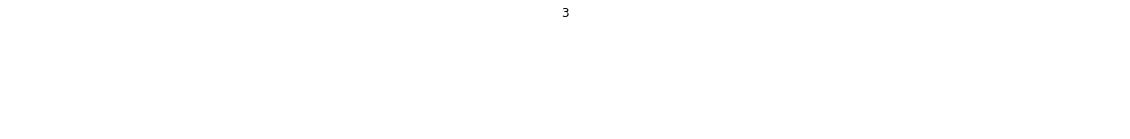

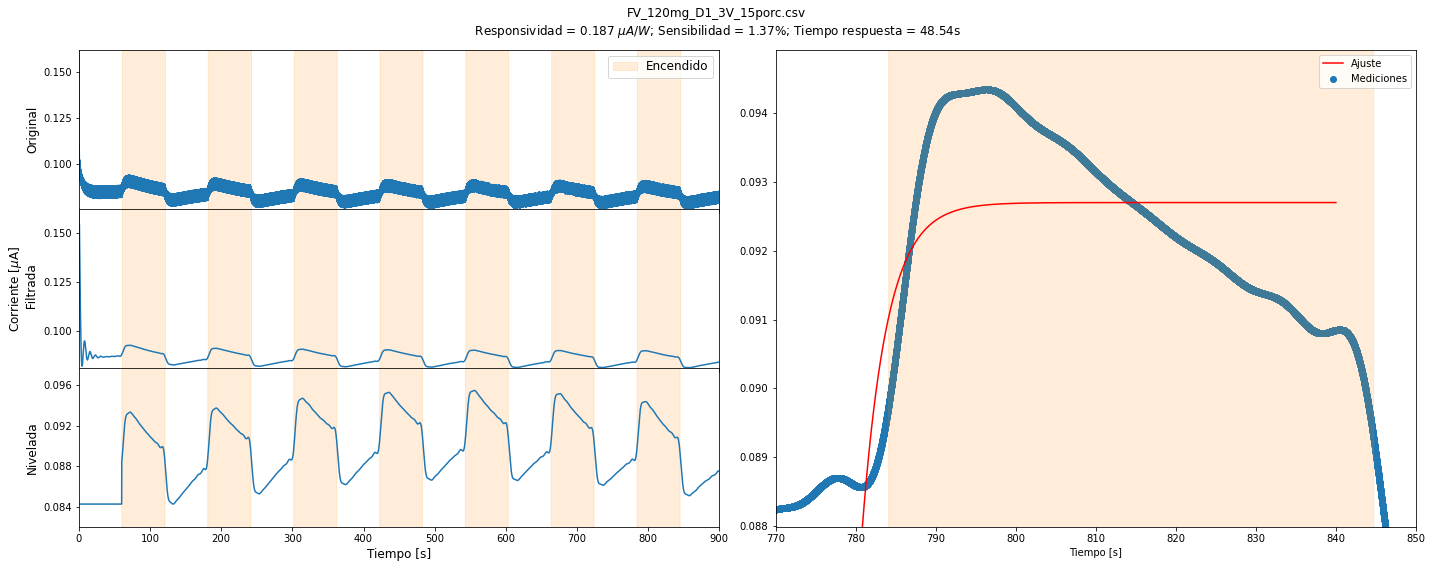

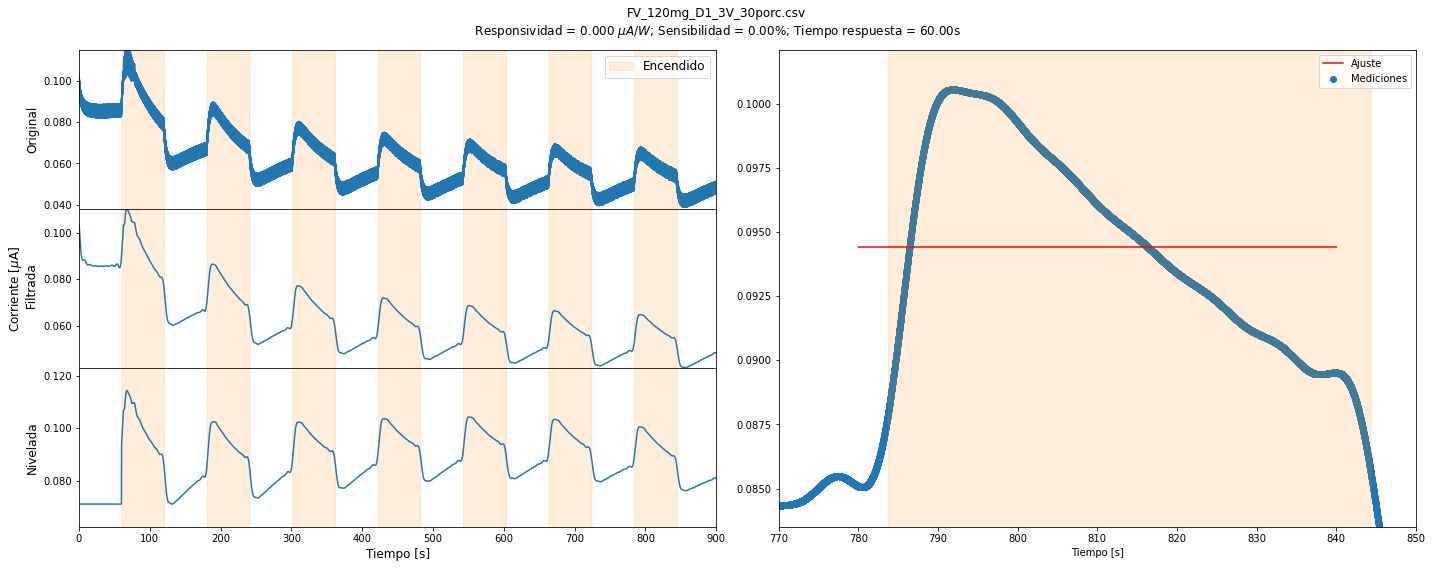

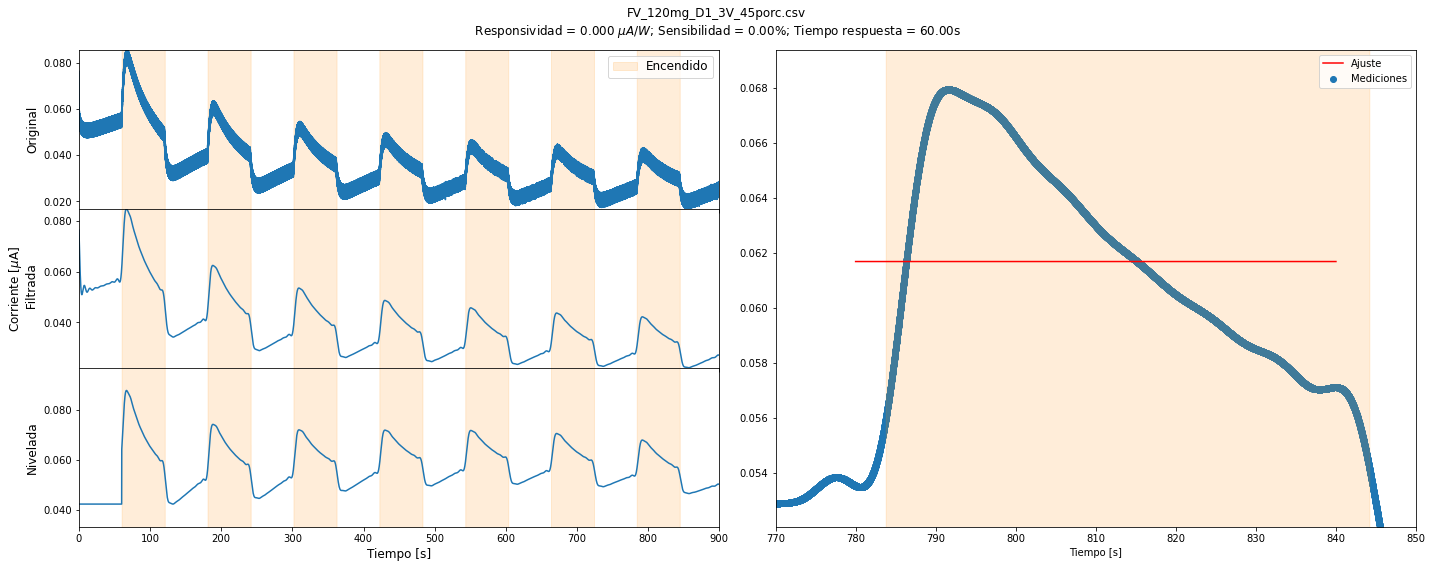

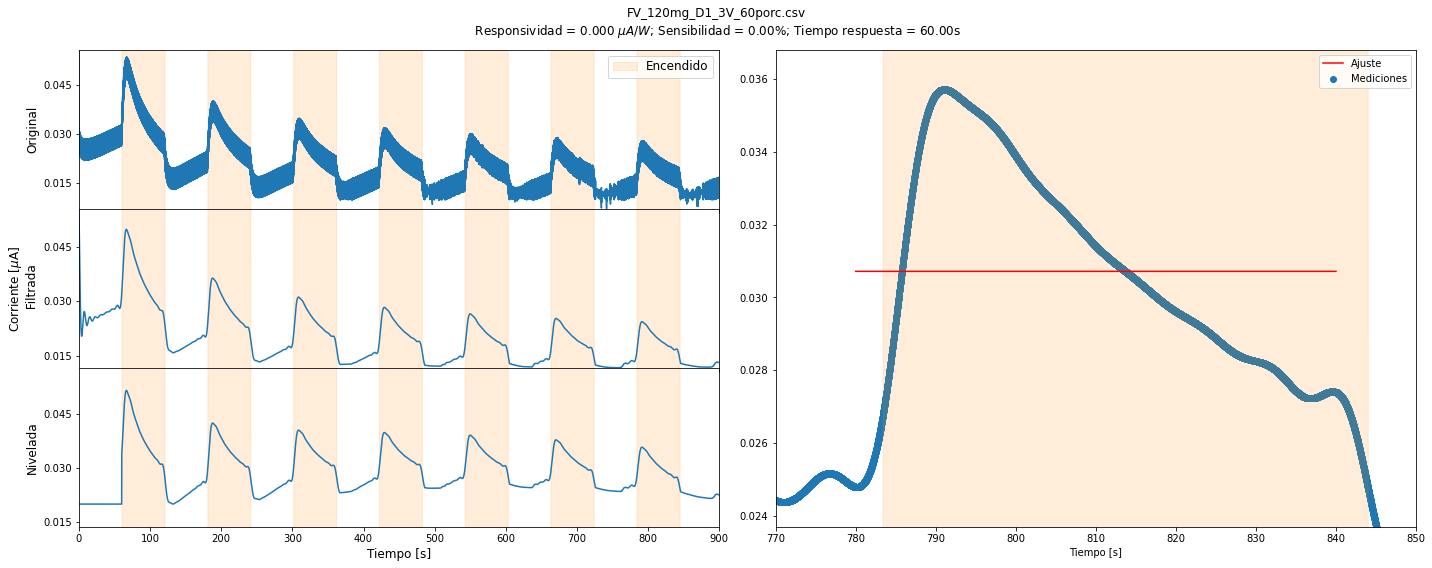

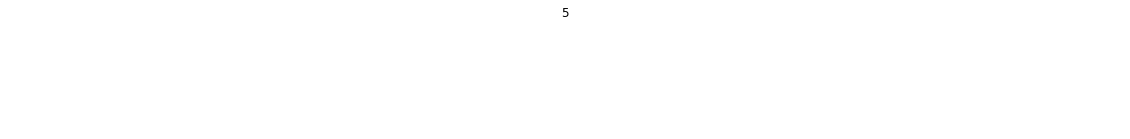

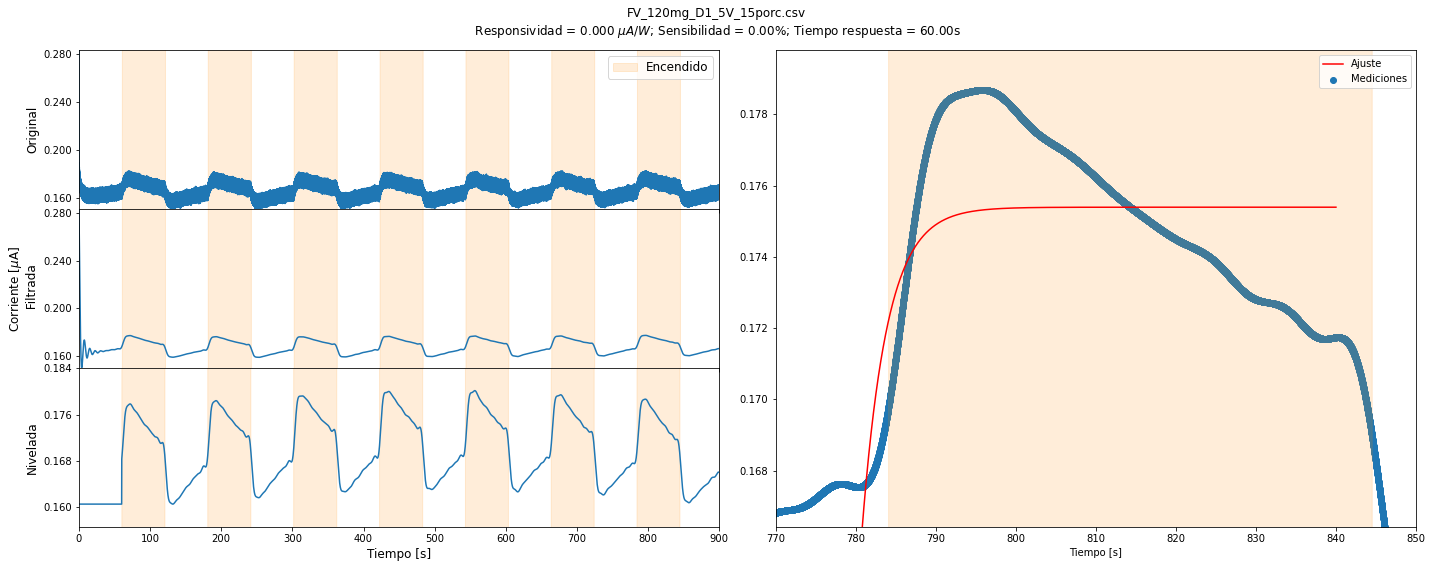

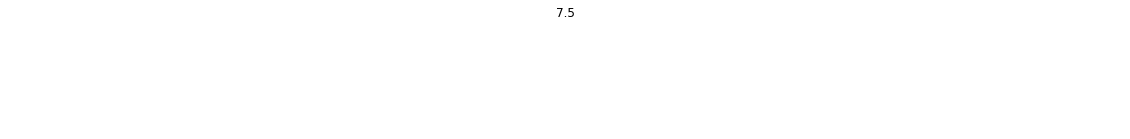

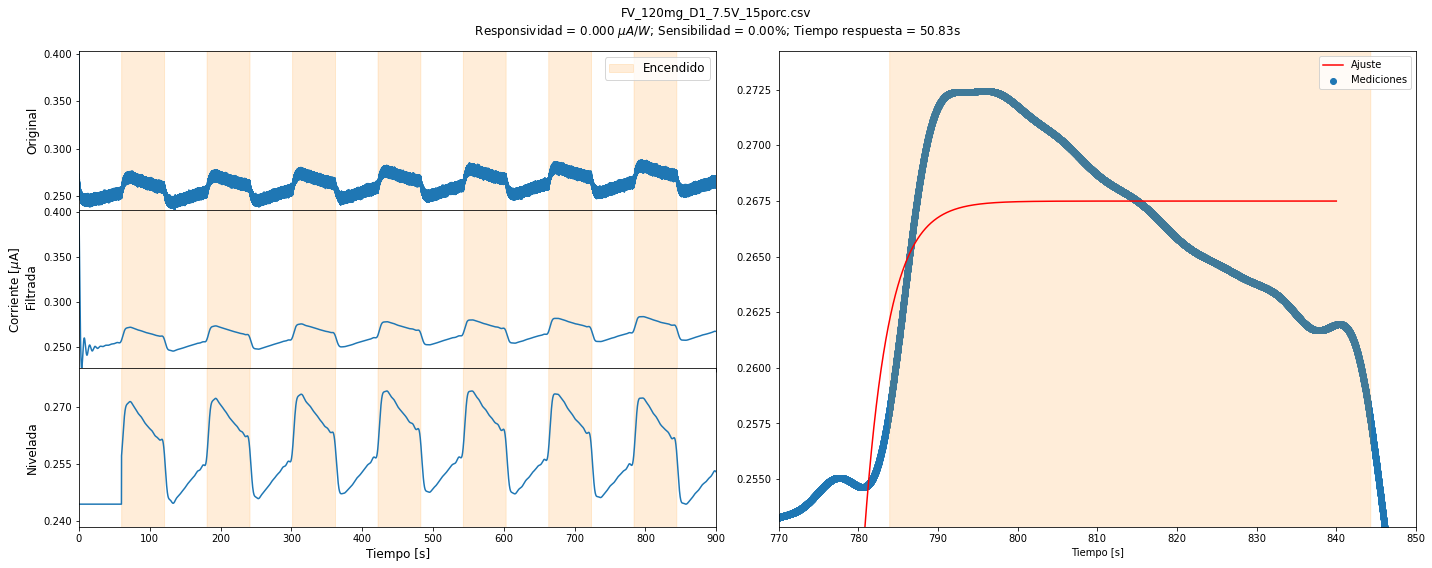

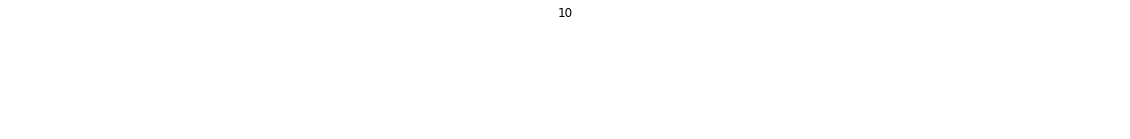

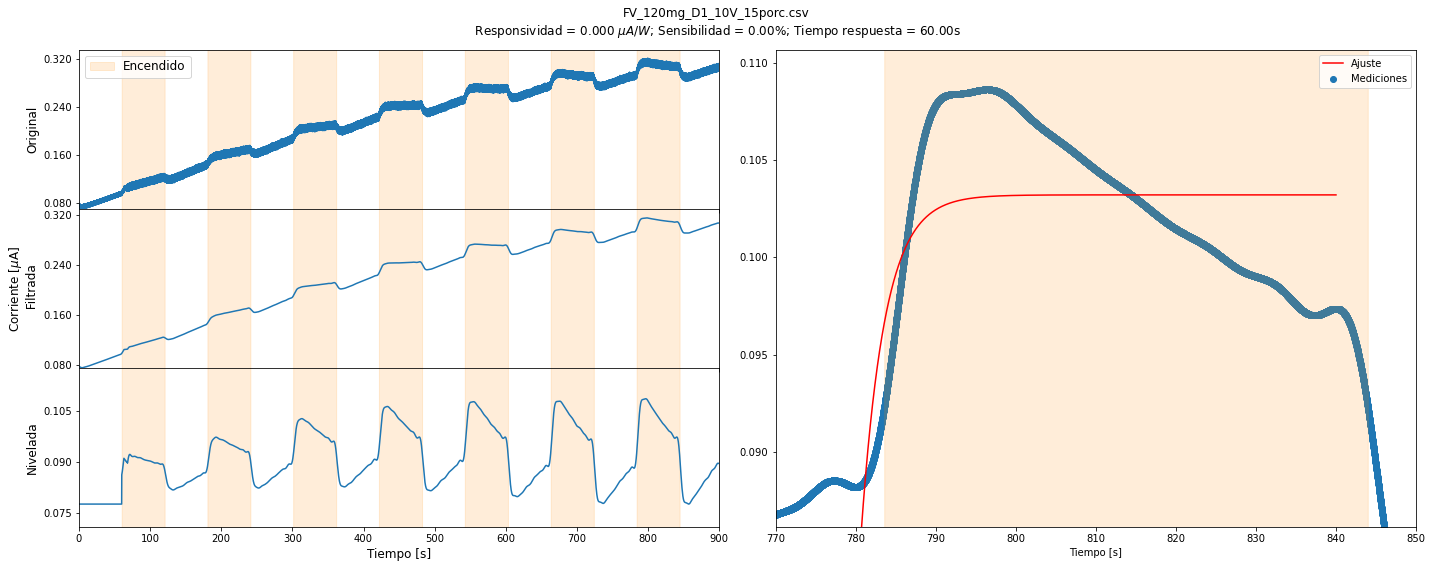

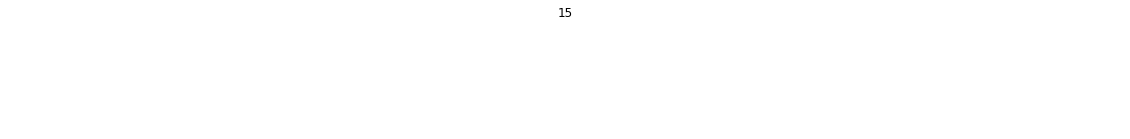

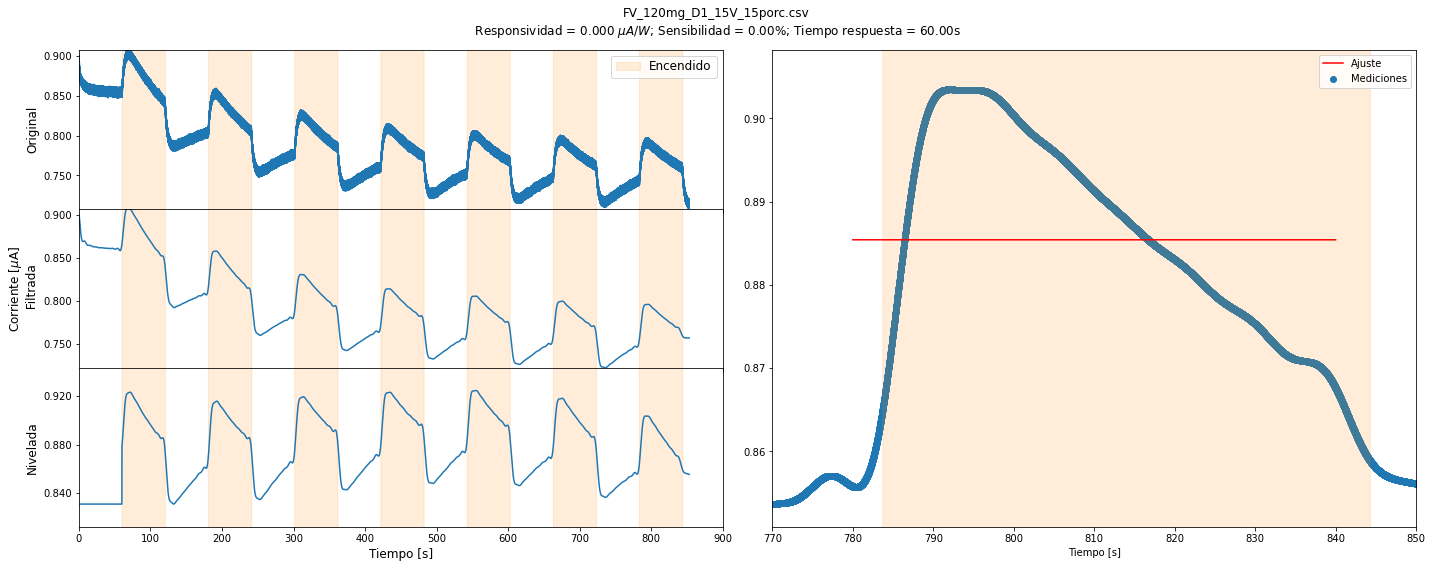

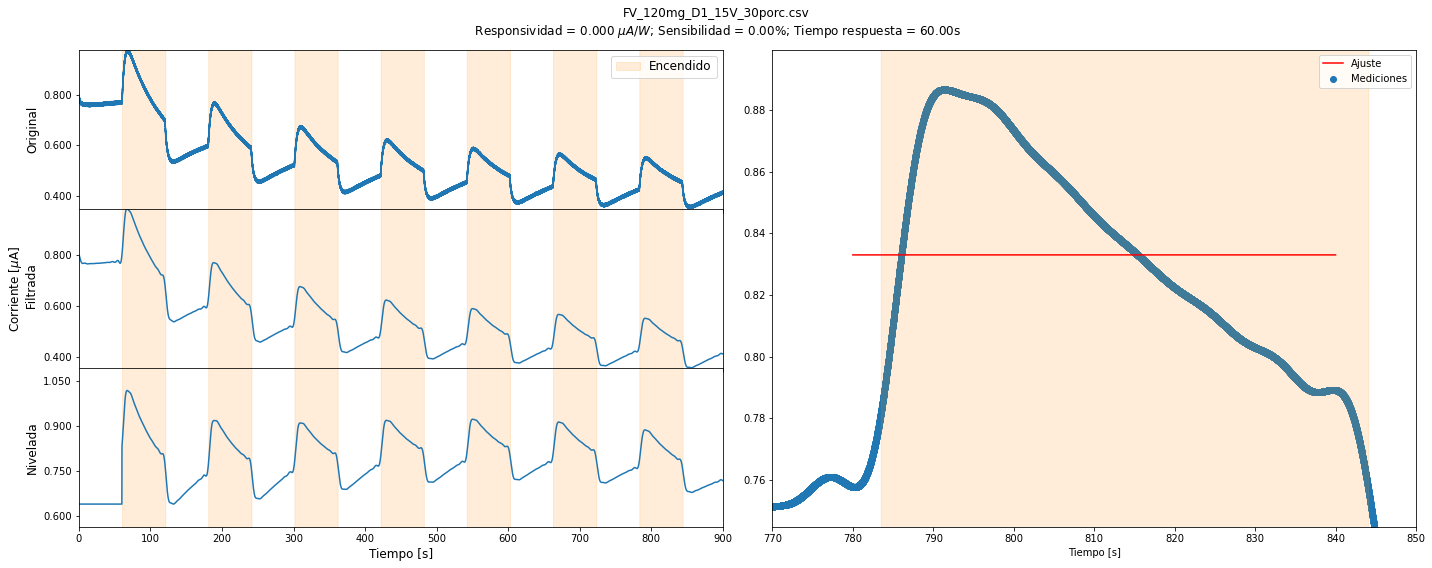

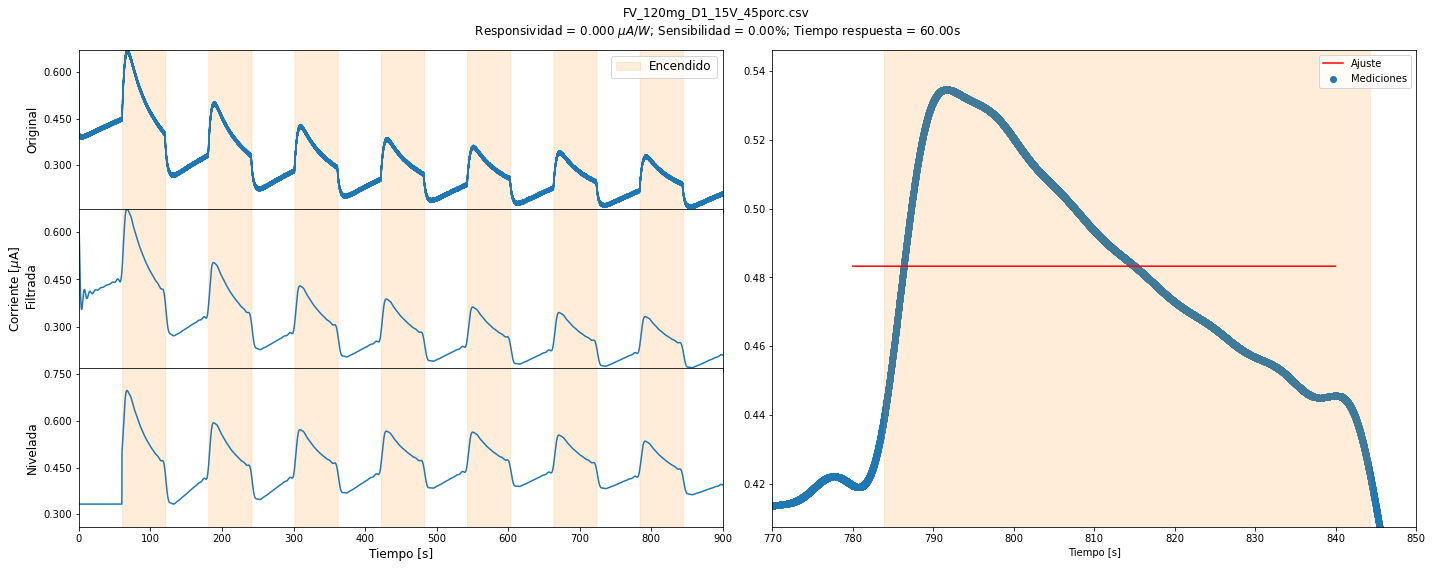

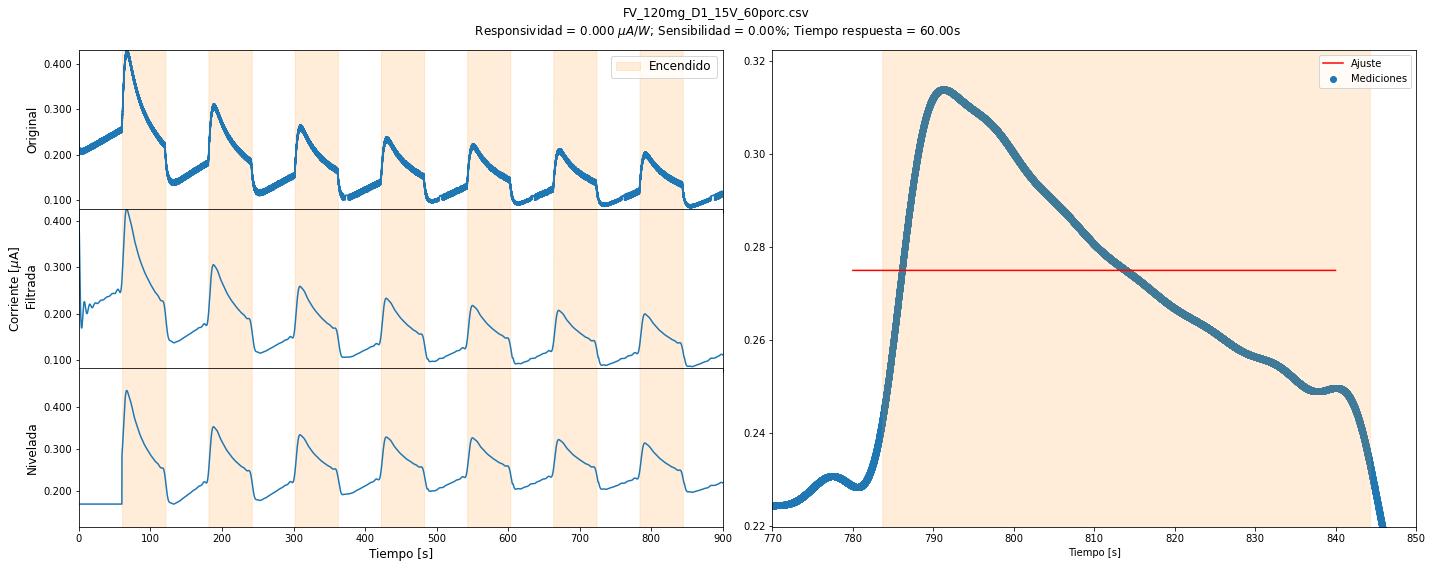

In [24]:
voltajes = [3,5,7.5,10,15]
# voltajes = [7.5]
# voltajes = voltajes[2:]
# responsividades = {}
# sensibilidades = {}
# tiempos = {}
# corrientes = {}
# fotocorrientes = {}

def generate_filenames(phi=20):
    if (phi in [5,7.5,10]):
        Vs = [3,5,7.5,10,15]
        filenames = ['FV_120mg_D1_{}V_15porc.csv'.format(phi,Vs)]
    else: 
        Vs = [15, 30, 45, 60]
        filenames = ['FV_120mg_D1_{}V_{}porc.csv'.format(phi,V) for V in Vs]
    return filenames



rango = (0,100000)
cut = 8/60
phis = [3, 5, 7.5, 10, 15]
P = [15,30,45,60,15,15,15,15,30,45,60]
# phis = [5,10,20]
# phis = [0,1]
# phis = [20]

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(5,1,hspace=0.2)
ax0,ax1,ax5,ax15,ax20 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0])
axes = (ax0,ax1,ax5,ax15,ax20)
i=0
for (phi,ax) in zip(phis,axes):
    
    filenames = generate_filenames(phi)
    plt.figure(figsize=(20,2))
    plt.axis('off')
    plt.title(phi)
    for filename in filenames:
        
        fig1 = plt.figure(figsize=(20,8))
        fig2,ax1 = plt.subplots(figsize=(12,8) )
        gs = fig1.add_gridspec(3,6,hspace=0)
        original,filtrada,corregida,zoom = fig1.add_subplot(gs[0,:3]),fig1.add_subplot(gs[1,:3]),fig1.add_subplot(gs[2,:3]),fig1.add_subplot(gs[:,3:])


        I0,Delta_I0,tau = extraer_datos_foto(filename,(original,filtrada,corregida),filter_function=basic_filter,filter_cut=cut,ajuste=ajuste,rango=rango,ax_single=zoom,reg_avg=ax1)
        r,s,Sr,Ss = calcular_desempeño(I0,Delta_I0,P[i])
        
        fig1.suptitle(filename+'\n Responsividad = {:.3f} $\mu A / W$; Sensibilidad = {:.2f}%; Tiempo respuesta = {:.2f}s'.format(r,s*100,tau))

        fig1.tight_layout()
        plt.close(fig)
#         plt.close(fig1)
        plt.close(fig2)
        i=i+1
    
print (r)

['FV_110mg_15V_60porciento.csv']

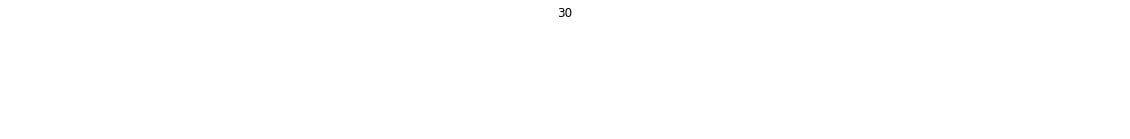

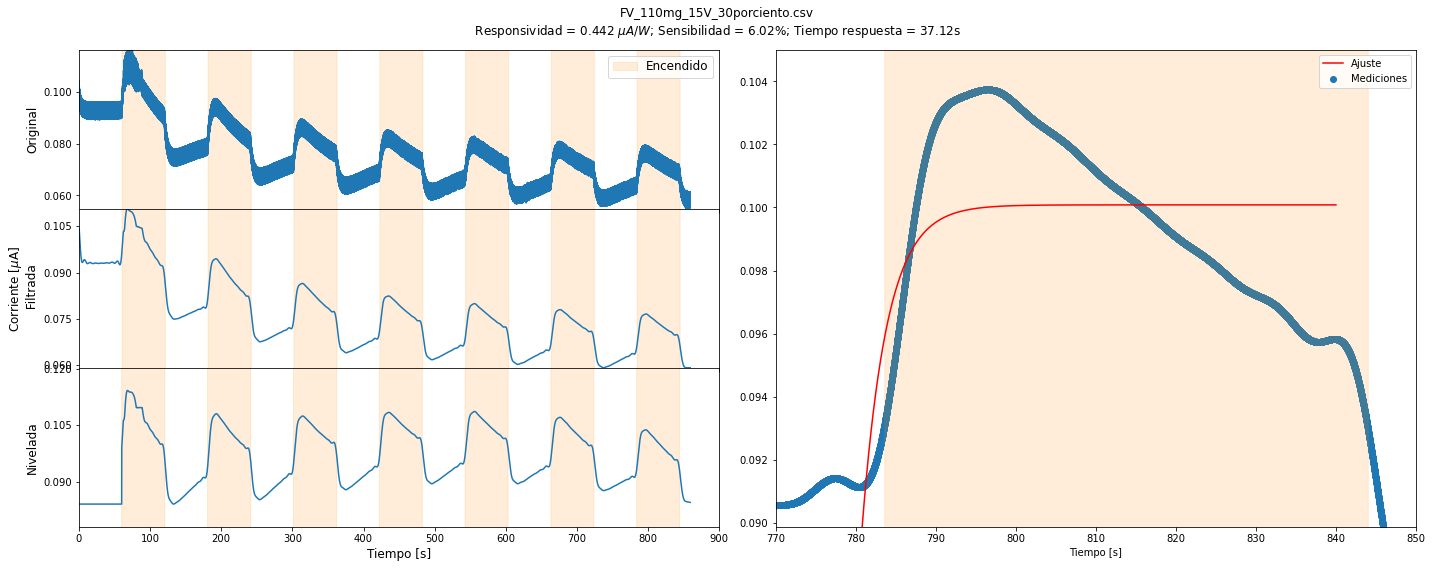

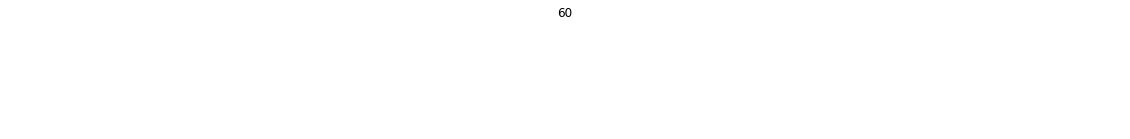

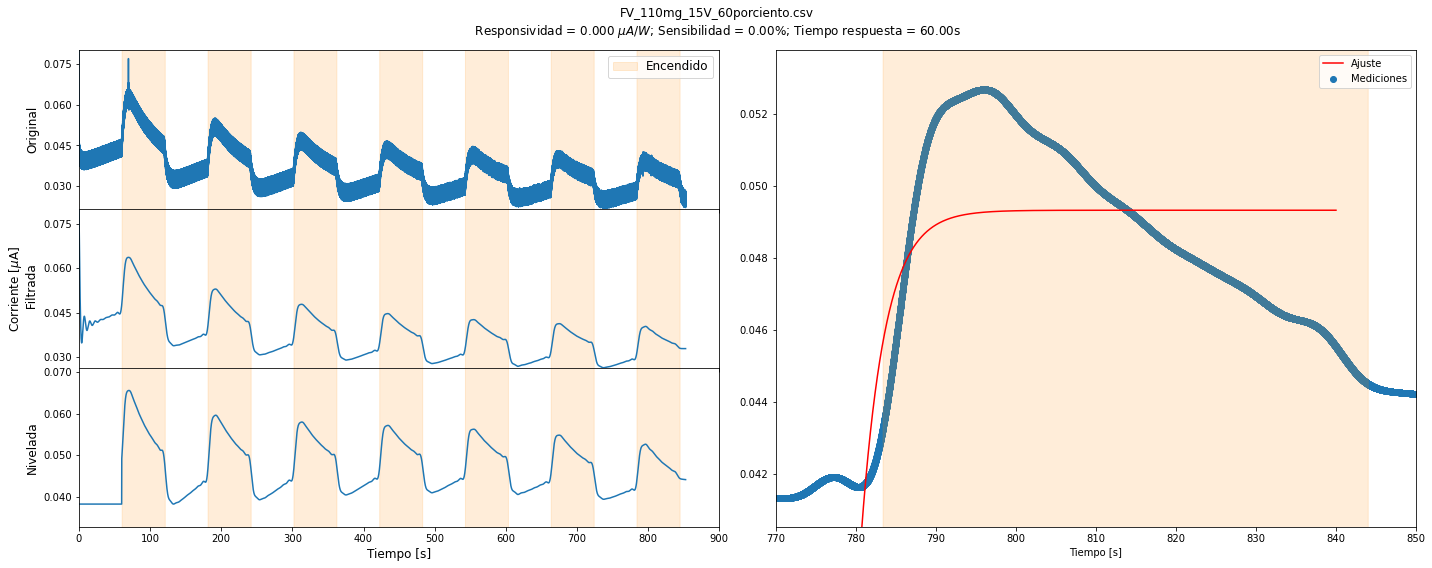

In [25]:
potencias = [30, 60]
def generate_filenames(phi=20):
    P = potencias
    filenames = ['FV_110mg_15V_{}porciento.csv'.format(phi,P)]
    return filenames



rango = (0,100000)
cut = 8/60

phis = [30, 60]
# phis = [5,10,20]
# phis = [0,1]
# phis = [20]

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(5,1,hspace=0.2)
ax0,ax1,ax5,ax15,ax20 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0])
axes = (ax0,ax1,ax5,ax15,ax20)

for (phi,ax) in zip(phis,axes):
    
    filenames = generate_filenames(phi)
    plt.figure(figsize=(20,2))
    plt.axis('off')
    plt.title(phi)
    for filename in filenames:
        
        fig1 = plt.figure(figsize=(20,8))
        fig2,ax1 = plt.subplots(figsize=(12,8) )
        gs = fig1.add_gridspec(3,6,hspace=0)
        original,filtrada,corregida,zoom = fig1.add_subplot(gs[0,:3]),fig1.add_subplot(gs[1,:3]),fig1.add_subplot(gs[2,:3]),fig1.add_subplot(gs[:,3:])


        I0,Delta_I0,tau = extraer_datos_foto(filename,(original,filtrada,corregida),filter_function=basic_filter,filter_cut=cut,ajuste=ajuste,rango=rango,ax_single=zoom,reg_avg=ax1)
        r,s,Sr,Ss = calcular_desempeño(I0,Delta_I0,phi)
#         ax.set_ylabel('{}%wt-G'.format(phi))

        fig1.suptitle(filename+'\n Responsividad = {:.3f} $\mu A / W$; Sensibilidad = {:.2f}%; Tiempo respuesta = {:.2f}s'.format(r,s*100,tau))

        fig1.tight_layout()
        plt.close(fig)
#         plt.close(fig1)
        plt.close(fig2)
filenames

['FV_110mg_15V.csv']

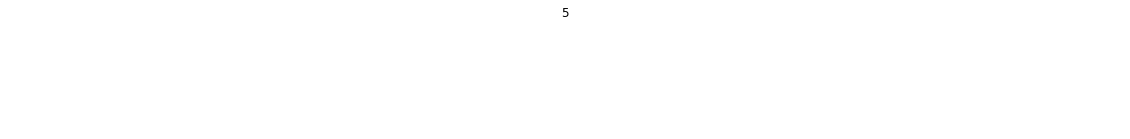

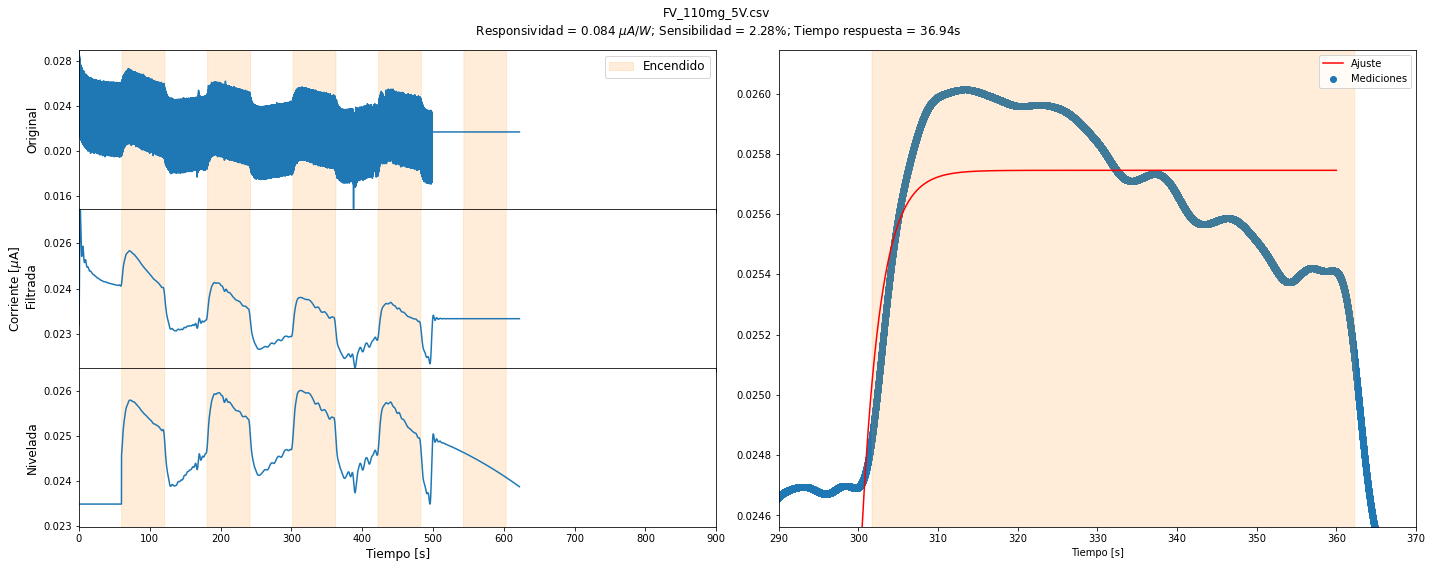

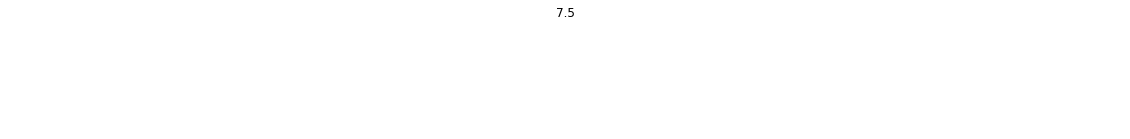

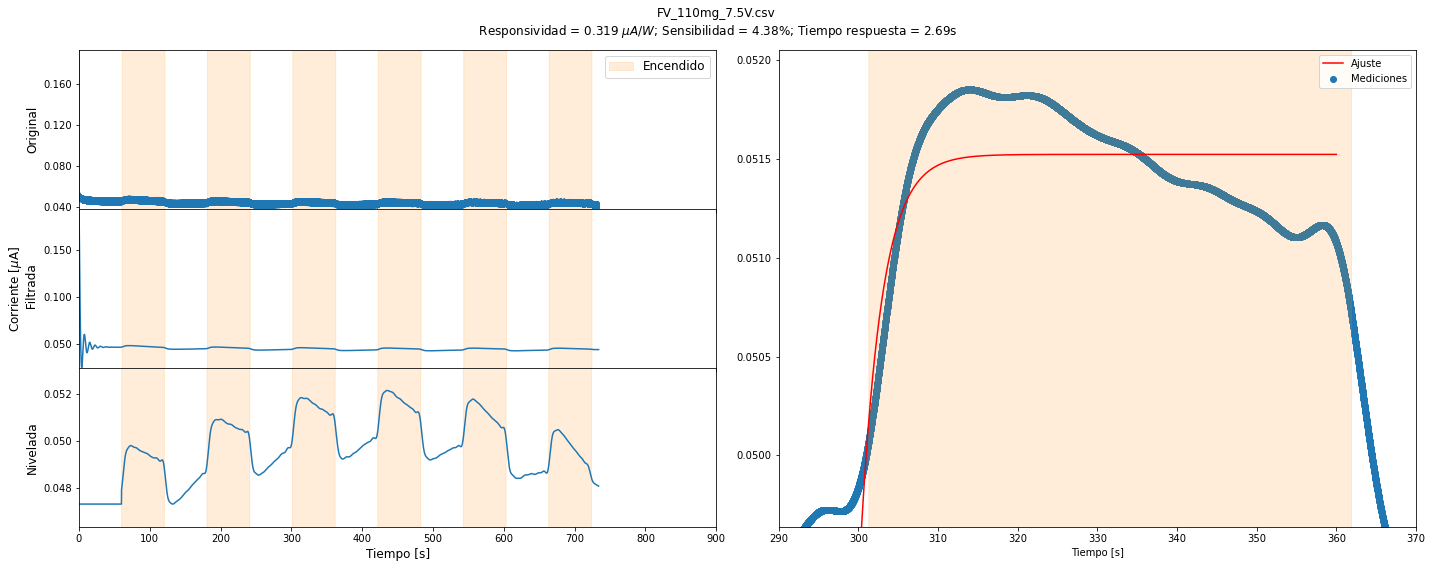

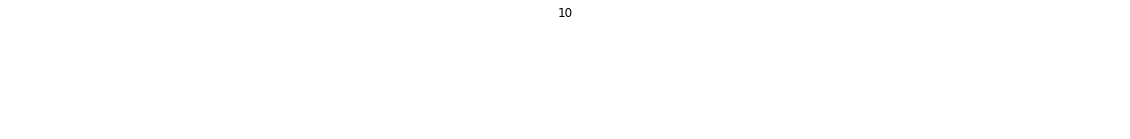

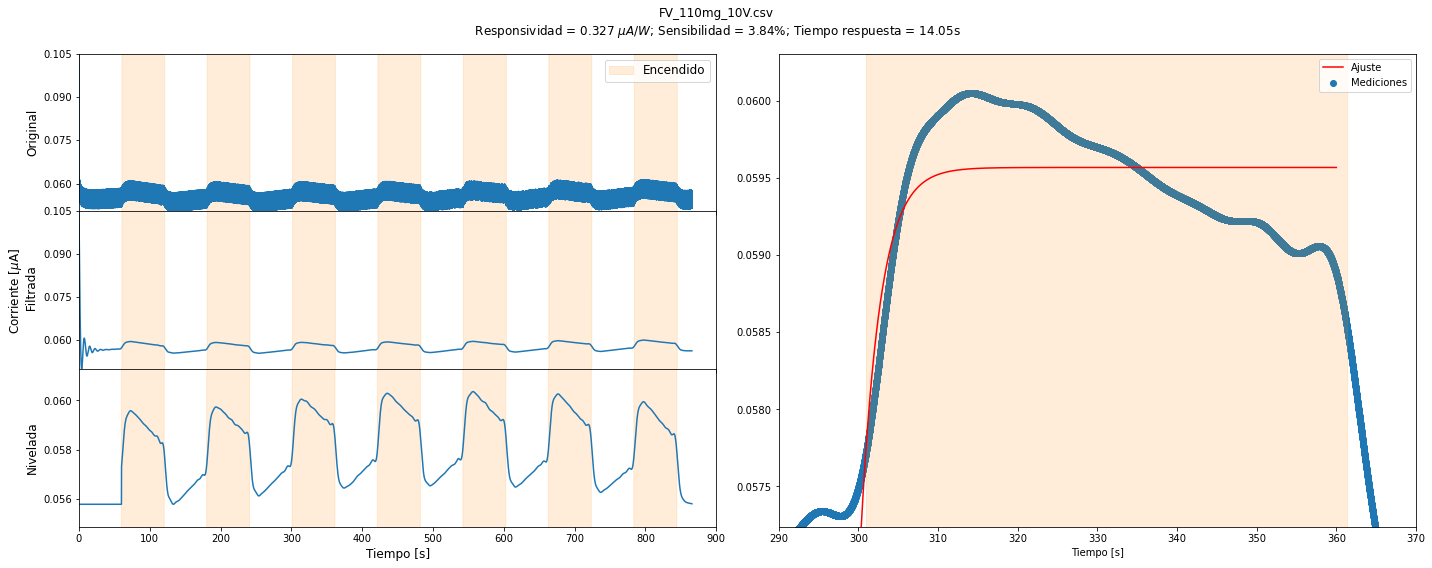

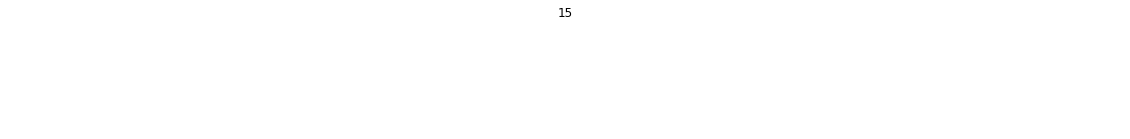

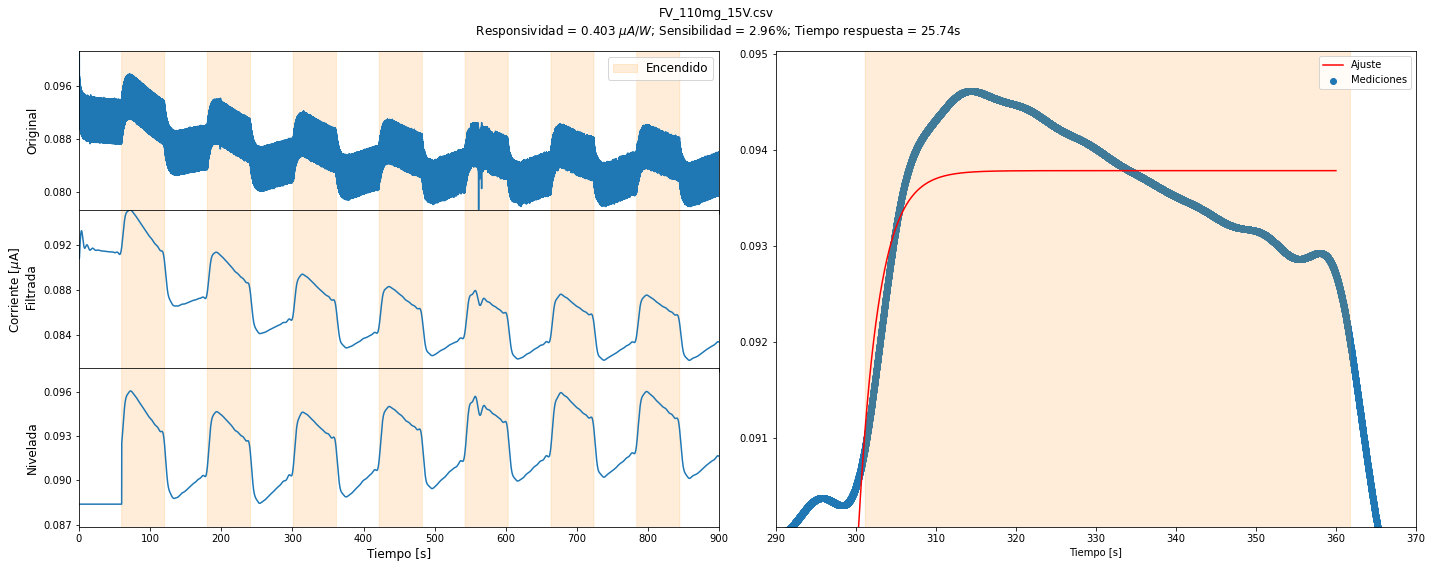

In [21]:
voltajes = [5, 7.5, 10, 15]
def generate_filenames(phi=20):
    V = voltajes
    filenames = ['FV_110mg_{}V.csv'.format(phi,P)]
    return filenames

rango = (0,1000000)
cut = 8/60

# phis = [5,10,20]
# phis = [0,1]
# phis = [20]

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(5,1,hspace=0.2)
ax0,ax1,ax5,ax15,ax20 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0])
axes = (ax0,ax1,ax5,ax15,ax20)

for (phi,ax) in zip(voltajes,axes):
    
    filenames = generate_filenames(phi)
    plt.figure(figsize=(20,2))
    plt.axis('off')
    plt.title(phi)
    for filename in filenames:
        
        fig1 = plt.figure(figsize=(20,8))
        fig2,ax1 = plt.subplots(figsize=(12,8) )
        gs = fig1.add_gridspec(3,6,hspace=0)
        original,filtrada,corregida,zoom = fig1.add_subplot(gs[0,:3]),fig1.add_subplot(gs[1,:3]),fig1.add_subplot(gs[2,:3]),fig1.add_subplot(gs[:,3:])


        I0,Delta_I0,tau = extraer_datos_foto(filename,(original,filtrada,corregida),filter_function=basic_filter,filter_cut=cut,ajuste=ajuste,rango=rango,ax_single=zoom,reg_avg=ax1)
        r,s,Sr,Ss = calcular_desempeño(I0,Delta_I0,15)
#         ax.set_ylabel('{}%wt-G'.format(phi))

        fig1.suptitle(filename+'\n Responsividad = {:.3f} $\mu A / W$; Sensibilidad = {:.2f}%; Tiempo respuesta = {:.2f}s'.format(r,s*100,tau))

        fig1.tight_layout()
        plt.close(fig)
#         plt.close(fig1)
        plt.close(fig2)
filenames